# Diffusion modeling

In [1]:
import warnings

warnings.filterwarnings("ignore")

The proposed method requires inferring a motion-less, reference DW map for a given diffusion orientation for which we want to estimate the misalignment.
Inference of the reference map is achieved by first fitting some diffusion model (which we will draw from [DIPY](https://dipy.org)) using all data, except the particular DW map that is to be aligned.
This data splitting scheme was introduced in {doc}`the LOGO splitter section in Introduction to dMRI data <data>`.

All models are required to offer the same API (application programmer interface):

1. The initialization takes a DIPY `GradientTable` as the first argument, and then arbitrary parameters as keyword arguments.
2. A `fit(data)` method, which only requires a positional argument `data`, a 4D array with DWI data.
3. A `predict(gradient_table)` method, which only requires a `GradientTable` as input.
   This method produces a prediction of the signal for every voxel in every direction represented in the input `gradient_table`.

```{attention}
By default, the code running in each Jupyter notebook is its own process.
We must reload the dataset again to use it in this notebook.
```

In [2]:
from eddymotion.dmri import DWI
from eddymotion.viz import plot_dwi
dmri_dataset = DWI.from_filename("../../data/dwi.h5")

## Implementing a trivial model

We will first start implementing a *trivial* model.
This model will always return the reference *b=0* map, regardless of the particular diffusion orientation model.
In other words, it is just a ***constant*** model.

Its simplicity does not diminish its great usefulness.
First, when coding it is very important to build up iteratively in complexity.
This model will allow to easily test the overall integration of the different components of our head-motion estimation algorithm.
Also, this model will allow a very straightforward implementation of registration to the *b=0* reference, which is commonly used to initialize the head-motion estimation parameters.

In [3]:
class TrivialB0Model:
    """
    A trivial model that returns a *b=0* map always.

    Implements the interface of :obj:`dipy.reconst.base.ReconstModel`.
    Instead of inheriting from the abstract base, this implementation
    follows type adaptation principles, as it is easier to maintain
    and to read (see https://www.youtube.com/watch?v=3MNVP9-hglc).

    """

    __slots__ = ("_S0",)

    def __init__(self, gtab, S0=None, **kwargs):
        """Implement object initialization."""
        if S0 is None:
            raise ValueError("S0 must be provided")

        self._S0 = S0

    def fit(self, *args, **kwargs):
        """Do nothing."""

    def predict(self, gradient, **kwargs):
        """Return the *b=0* map."""
        return self._S0

The model can easily be initialized as follows (assuming we still have our dataset loaded):

In [4]:
model = TrivialB0Model(
    dmri_dataset.gradients,
    S0=dmri_dataset.bzero,
)

Then, at each iteration of our estimation strategy, we will fit this model to the data, after holding one particular direction (`data_test`) out, using the `logo_split` method of the dataset. In every iteration, this finds the b=0 volumes in the data and averages their values in every voxel:

In [5]:
data_train, data_test = dmri_dataset.logo_split(10)
model.fit(data_train[0])

Finally, we can generate our registration reference with the `predict()` method:

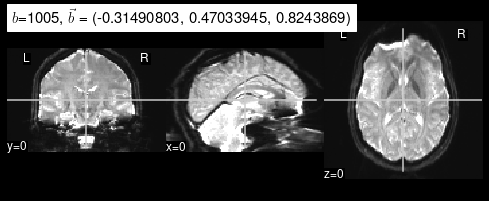

In [6]:
predicted = model.predict(data_test[1])
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1]);

As expected, the *b=0* doesn't look very much like the particular left-out direction, but it is a start!

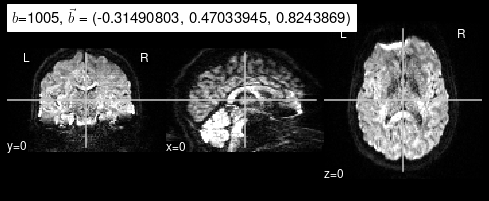

In [7]:
plot_dwi(data_test[0], dmri_dataset.affine, gradient=data_test[1]);

## Implementing a *regression to the mean* model

```{admonition} Exercise
Extend the `TrivialB0Model` to produce an average of *all other* diffusion directions, instead of the *b=0*.
```

In [8]:
class AverageDWModel:
    """A trivial model that returns an average map."""

    __slots__ = ("_data",)

    def __init__(self, gtab, **kwargs):
        """Implement object initialization."""
        return  # do nothing at initialization time

    def fit(self, data, **kwargs):
        """Calculate the average."""
        # self._data =  # Use numpy to calculate the average.

    def predict(self, gradient, **kwargs):
        """Return the average map."""
        return self._data

**Solution**

In [9]:
class AverageDWModel:
    """A trivial model that returns an average map."""

    __slots__ = ("_data",)

    def __init__(self, gtab, **kwargs):
        """Implement object initialization."""
        return  # do nothing at initialization time

    def fit(self, data, **kwargs):
        """Calculate the average."""
        self._data =  data.mean(-1)

    def predict(self, gradient, **kwargs):
        """Return the average map."""
        return self._data

```{admonition} Exercise
 Use the new `AverageDWModel` you just created.
```

**Solution**

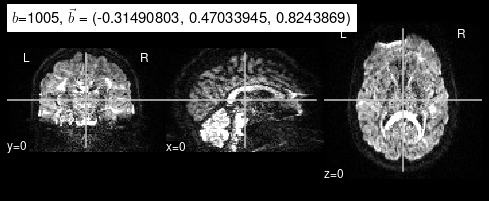

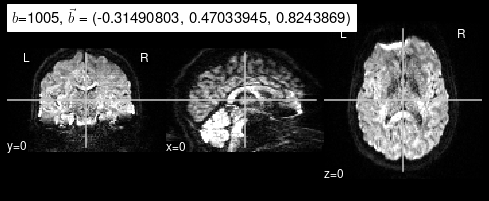

In [10]:
model = AverageDWModel(
    dmri_dataset.gradients,
)
model.fit(data_train[0])
predicted = model.predict(data_test[1])
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1]);
plot_dwi(data_test[0], dmri_dataset.affine, gradient=data_test[1]);

## Investigating the tensor model

Now, we are ready to use the diffusion tensor model.
We will use the wrap around DIPY's implementation that we distribute with `eddymotion`.

In [11]:
from tempfile import mkstemp
from pathlib import Path
import requests

if dmri_dataset._filepath.exists():
    dmri_dataset._filepath.unlink()
url = "https://files.osf.io/v1/resources/8k95s/providers/osfstorage/6070b4c2f6585f03fb6123a2"
datapath = Path(mkstemp(suffix=".h5")[1])
if datapath.stat().st_size == 0:
    datapath.write_bytes(
        requests.get(url, allow_redirects=True).content
    )

dmri_dataset = DWI.from_filename(datapath)
datapath.unlink()
data_train, data_test = dmri_dataset.logo_split(88, with_b0=True)

### The model factory

To permit flexibility in selecting models, the `eddymotion` package offers a `ModelFactory` that implements the *facade design pattern*.
This means that `ModelFactory` makes it easier for the user to switch between models:

In [12]:
from eddymotion.model import ModelFactory

# We are using now a full dataset, we need to split the data again

model = ModelFactory.init(
    gtab=data_train[1],
    model="DTI",
    S0=dmri_dataset.bzero,
)

### Leveraging the `fit()` / `predict()` API

The `ModelFactory` returns a model object that is compliant with the interface sketched above:

In [13]:
model.fit(data_train[0])
predicted = model.predict(data_test[1])

Now, the predicted map for the particular ***b*** gradient looks much closer to the original:

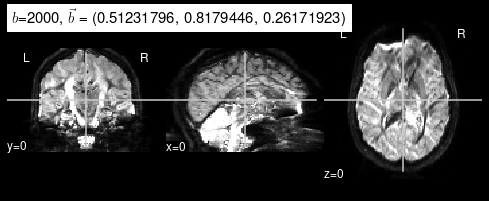

In [14]:
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1], black_bg=True);

Here's the original DW map, for reference:

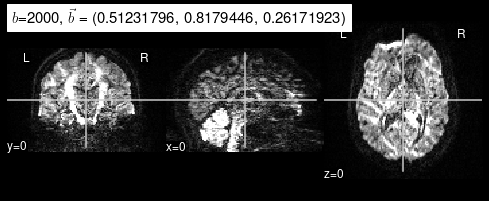

In [15]:
plot_dwi(data_test[0], dmri_dataset.affine, gradient=data_test[1]);

```{admonition} Exercise
Use the `ModelFactory` to initialize a `"DKI"` (diffusion Kurtosis imaging) model.
```

**Solution**

In [16]:
model = ModelFactory.init(
    gtab=data_train[1],
    model="DKI",
    S0=dmri_dataset.bzero,
)

Once the model has been initialized, we can easily generate a new prediction.

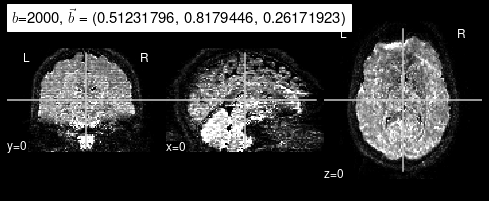

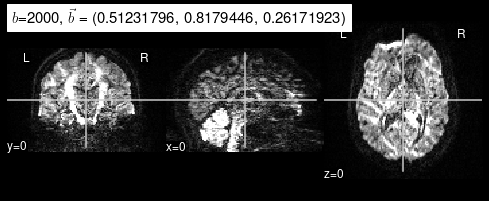

In [17]:
model.fit(data_train[0])
predicted = model.predict(data_test[1])
plot_dwi(predicted, dmri_dataset.affine, gradient=data_test[1], black_bg=True);
plot_dwi(data_test[0], dmri_dataset.affine, gradient=data_test[1]);

## Next steps: image registration

Once we have our model factory readily available, it will be easy to generate predictions that we can use for reference in image registration.